In [46]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract
This blog post explores logistic regression. I used previous code to create a linear model, then implemented logistic regression off of the linear model. My logistic regression model includes a logistic regression class and a gradient descent optimizer. I then used these classes to experiment on several data sets with different gradient descent strategies. To start, I conducted experiments around vanilla gradient descent ($\beta$ = 0), which gradually reduced the loss of the model. I compared vanilla gradient descent to spicy gradient descent (which uses momentum). I found that spicy gradient descent affects the loss far less gradually, and reduces loss more effectively. Finally, I experimented with overfitting the model to a training data set with more dimensions that points. I created a model that performed to 100% accuracy in the training data, but only around 80% in the testing data, demonstrating overfitting.  

## Part A: Implement Logistic Regression

Source code of my implementation of logistic regression: https://github.com/tristanmeyer2/tristanmeyer2.github.io/blob/main/posts/LogisticRegression/logistic.py

## Part B: Experiments

In [47]:
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix]*2-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

Defining three methods: plotting data, drawing a line on a visualization, creating data.
The plot_data() function plots two dimensional data on a scatter plot
The draw_line() function draws a "separating" line that maximizes classification accuracy on two dimensional data.  

## Vanilla Gradient Descent 

Vanilla gradient descent is characterized by $\beta$ = 0, and $\alpha$ being sufficiently small

In [48]:
torch.manual_seed(1234)

X, y = classification_data(noise = 0.5)

Generating data points. 

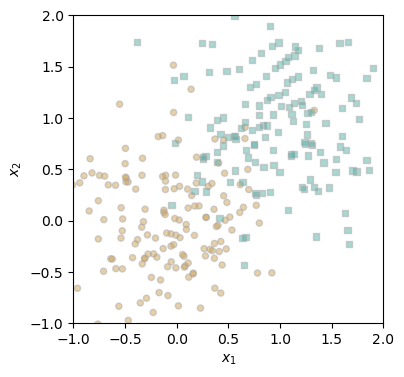

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_data(X, y, ax)

Visualizing the data in a scatter plot. As the plot shows, this data is not linearly separable and has a fair amount of overlap between the two classifications of the data. 

In [50]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1
loss_vec_van = []
maxIterations = 1500
currIteration = 0

while loss > 0 and currIteration < maxIterations:
    loss = LR.loss(X, y) 
    loss_vec_van.append(loss)
    opt.step(X, y, alpha = 0.2, beta = 0)
    currIteration += 1

Implementing and running a training loop over a maximum of 100 iterations, calling the step() function in my logistic regression model and keeping track of the loss at each iteration. As mentioned, vanilla gradient descent involveds a $\beta$ = 0 and in this case an $\alpha$ = 0.2

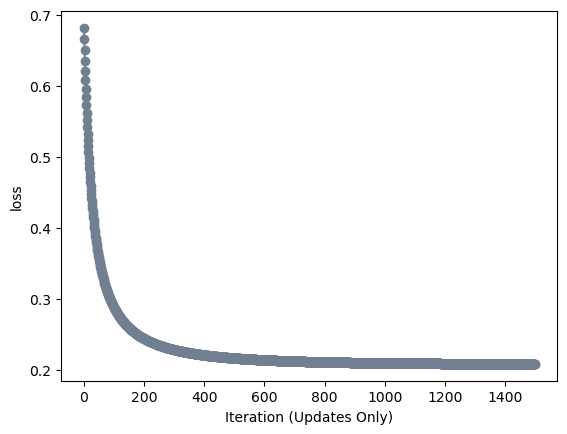

In [51]:
plt.plot(loss_vec_van, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_van)), loss_vec_van, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

This visualization shows the progression of the loss over 1500 iterations. As the plot shows, using vanilla gradient descent over 1500 iterations, the models loss converges  around 0.20. 

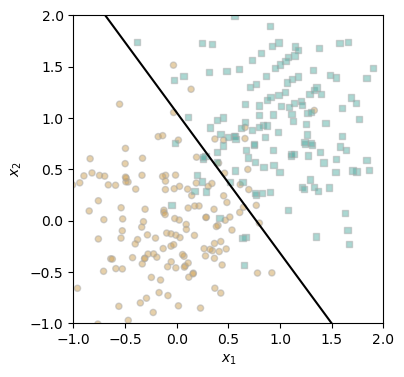

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_data(X, y, ax)
draw_line(LR.w, -1, 2, ax, color = "black")

This visualization shows the classification data with a plotted line that minimizes the empirical risk of the model.

## Benefits of Momentum

In [53]:
torch.manual_seed(1235)
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1
loss_vec = []
maxIterations = 100
currIteration = 0


while loss > 0 and currIteration < maxIterations:
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    opt.step(X, y, alpha = 0.2, beta = 0.9)
    currIteration += 1

To demonstrate gradient descent with momentum, the same training loop is used as in vanilla gradient descent; however, the $\beta$ = 0.9. 

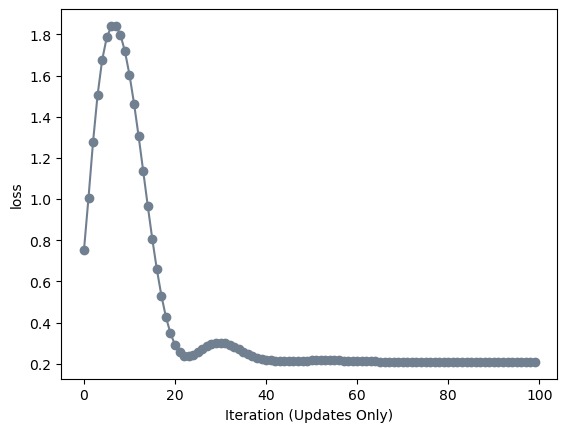

In [54]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

This visualization shows the progression of the loss over 100 iterations. As the plot shows, using momentum in gradient descent over 100 iterations, the models loss decreases to around 0.2. 

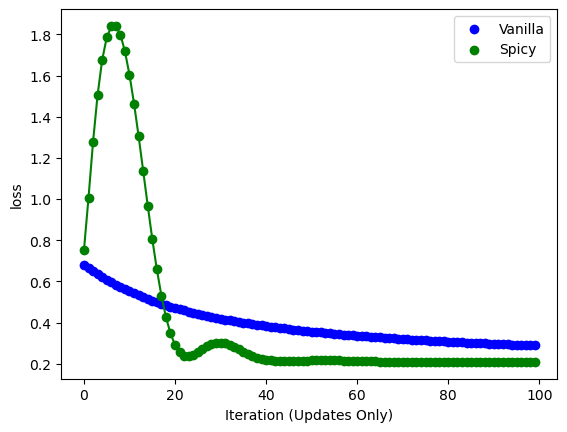

In [55]:
plt.plot(loss_vec_van[:100], color = "blue")
plt.scatter(torch.arange(100), loss_vec_van[:100], color = "blue", label="Vanilla")
plt.legend(["Vanilla"])
plt.plot(loss_vec[:100], color = "green")
plt.scatter(torch.arange(100), loss_vec[:100], color = "green", label="Spicy")
plt.legend()
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

This plot shows the difference between vanilla gradient descent and gradient descent with momentum over the same number of iterations. As shown, although the loss spikes to a value over 1.8, the function reaches a value around 0.2 in only 40 iterations, which is much faster than the vanilla gradient descent reaching a loss value of around 0.3 in 100 iterations.    

## Overfitting

In [56]:
torch.manual_seed(1)
X_train, y_train = classification_data(n_points= 50, noise = 0.3, p_dims= 100)
torch.manual_seed(2)
X_test, y_test = classification_data(n_points= 50, noise = 0.3, p_dims= 100)


Generating two sets of data (training and testing); both sets have 50 points and the 100 dimensions, with a noise value of 0.3. 

In [57]:
torch.manual_seed(1238)
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1
loss_vec = []
maxIterations = 1000
currIteration = 0


while loss > 0 and currIteration < maxIterations:
    loss = LR.loss(X_train, y_train) 
    loss_vec.append(loss)
    opt.step(X_train, y_train, alpha = 0.2, beta = 0.9)
    currIteration += 1

Running a training loop on the training dataset over 1000 iterations, with $\beta$ = 0.9 and $\alpha$ = 0.2. 

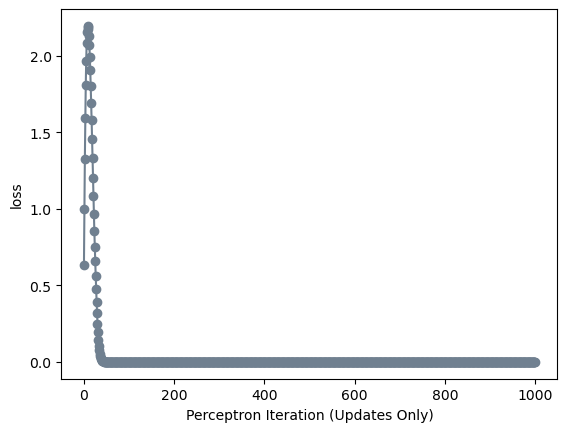

In [58]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This visualization shows the progression of the loss over 1000 iterations on the training dataset. As the plot shows, over 1000 iterations, the model reaches a value near 0. 

In [59]:
from sklearn.metrics import accuracy_score
preds = LR.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, preds)*100:.2f}%')

Accuracy: 100.00%


Using the predict function in our linear model and the accuracy_score function, our model performs to 100.00% accuracy on the training data. 

In [60]:
preds_test = LR.predict(X_test)
print(f'Accuracy on test data: {accuracy_score(y_test, preds_test)*100:.2f}%')

Accuracy on test data: 82.00%


If our trained model is used to predict the data in the test dataset (using the same functions as above), the accuracy of the model decreases to 82.00% on the testing data. This difference between accuracy in our training data and testing data implies that the model is overfit to the training data, resulting in loss in the testing data. 

## Part C: Writing 

Through the process of implementing logistic regression and testing it, I practiced my skills with torch and pandas and learned about the math behind the model. Coding the logistic regression and gradient descent classes helped me practice matrix manipulation and developed my ability to write efficient code. Further, the testing of both vanilla and spicy gradient descent demonstrated the difference that momentum has on gradient descent. Testing the data with more dimensions than data points helped me understand how overfitting occurs and how to prevent it. 